# Spectral Clustering


In this exercise, you will implement spectral clustering and try it on diffent kinds of data, for instance:

* N-blob: Random points in $\mathbb{R}^2$ according to N Gaussian distributions with different means;

* Two moons: Random points shaped as two intertwined moons; 

* Point and circle: random points from a concentrated Gaussian point in the middle and a wide circle around it.

The first step after generating the data is to construct a graph and, for that, we need a similarity function. In this exercise we will use the following similarity:

$$
d(x_i, x_j) = \exp\left(-\frac{||x_i-x_j||_2^2}{2\sigma^2}\right)
$$

Using this similarity, we can compute the weight matrix W representing the graph, compute the graph Laplacian L and finally use its eigenvectors for clustering.


## Setup

In [3]:
from generate_data import worst_case_blob, blobs, two_moons, point_and_circle
from utils import plot_clusters, min_span_tree, plot_graph_matrix, min_span_tree
from utils import plot_clustering_result, plot_the_bend
from sklearn.cluster import KMeans
import sklearn.metrics as skm
import numpy as np
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.metrics import pairwise_distances

## Generating the data

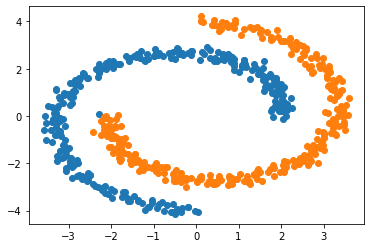

In [16]:
# Example

for fn in [two_moons]:  #  try also [worst_case_blob, point_and_circle, blobs]
    X, Y = fn(num_samples=600)
    plot_clusters(X, Y, fignum=str(fn))
    
# You can check the documentation of each function to see the optional parameters, e.g.:
worst_case_blob?

## Building similarity graph

In [26]:
def build_similarity_graph(X, var=1.0, eps=0.0, k=0):
    """
    TO BE COMPLETED.

    Computes the similarity matrix for a given dataset of samples. 
    If k=0, builds epsilon graph. 
    Otherwise, builds kNN graph.

    Parameters
    ----------
    X : numpy array
        (n x m) matrix of m-dimensional samples
    var : double 
        the sigma value for the exponential function, already squared
    eps : double
        threshold for epsilon graphs
    k : int
        The number of neighbours k for k-nn. If zero, use epsilon-graph

    Returns
    -------
        W: (n x n) dimensional matrix representing the weight matrix of the graph
    """
    n = X.shape[0]
    W = np.zeros((n, n))

    """
    Build similarity graph, before threshold or kNN
    similarities: (n x n) matrix with similarities between all possible couples of points.
    The similarity function is d(x,y)=exp(-||x-y||^2/(2*var))
    """
    similarities = np.exp(-np.square(pairwise_distances(X, X))/ (2*var))

    # If epsilon graph
    if k == 0:
        """
        compute an epsilon graph from the similarities             
        for each node x_i, an epsilon graph has weights             
        w_ij = d(x_i,x_j) when w_ij >= eps, and 0 otherwise          
        """
        W = np.where(similarities >= eps, similarities, 0)
        np.fill_diagonal(W, 0)
    # If kNN graph
    elif k != 0:
        """
        compute a k-nn graph from the similarities                   
        for each node x_i, a k-nn graph has weights                  
        w_ij = d(x_i,x_j) for the k closest nodes to x_i, and 0     
        for all the k-n remaining nodes                              
        Remember to remove self similarity and                       
        make the graph undirected                                    
        """
        index_sort = np.argsort(-similarities, axis = 1)
        #for k in range(n):
        #    W[k,:][neighbors[k,:]] = d[k,:][neighbors[k,:]]
        W[np.tile(np.arange(n), (k, 1)).T, index_sort[:, 1:k+1]] =  similarities[np.tile(np.arange(n), (k, 1)).T, index_sort[:, 1:k+1]]
        W = (W + W.T)/2
    return W


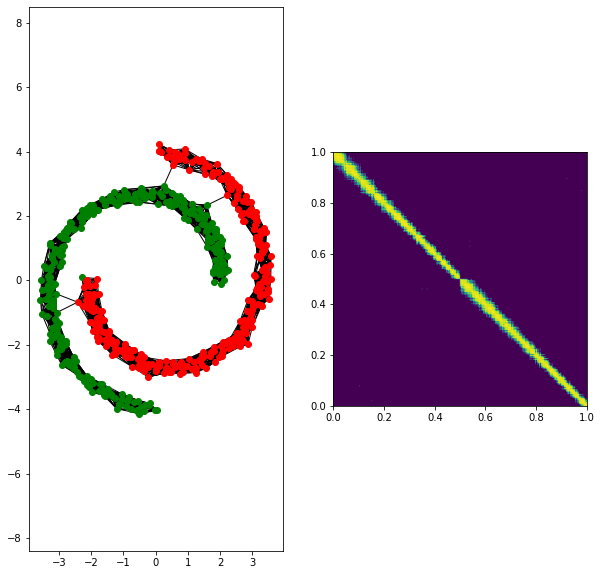

In [17]:
# Example

W = build_similarity_graph(X, eps=0.76, k=0)
plot_graph_matrix(X, Y, W, figsize=(10, 10))  # shows the graph and the visualization of W

## Computing the Laplacian

In [178]:
def build_laplacian(W, laplacian_normalization='unn'):
    """
    Compute graph Laplacian.

    Parameters
    ----------
    W : numpy array
        Adjacency matrix (n x n)
    laplacian_normalization : str
        String selecting which version of the laplacian matrix to construct.
            'unn':  unnormalized,
            'sym': symmetric normalization
            'rw':  random-walk normalization   

    Returns
    -------
    L: (n x n) dimensional matrix representing the Laplacian of the graph
    """
    n = W.shape[0]
    D = np.diag(W.sum(axis = 0))
    if laplacian_normalization == 'unn':
        L = D - W
    elif laplacian_normalization == 'sym':
        D_sym =  np.diag(1/np.sqrt(W.sum(axis = 0)))
        L = np.eye(n) - (D_sym.dot(W)).dot(D_sym)
    elif laplacian_normalization == 'rw':
        D_inv = np.linalg.inv(D)
        L = np.eye(n) - D_inv.dot(W)
    return L

## Clustering

In [169]:
from sklearn.cluster import KMeans
def spectral_clustering(L, chosen_eig_indices=None, num_classes=2, kmeans = True):
    """
    Parameters
    ----------
    L : numpy array
        Graph Laplacian (standard or normalized)
    choosen_eig_indices : list or None
        Indices of eigenvectors to use for clustering. 
        If None, use adaptive choice of eigenvectors.
    num_classes : int 
        Number of clusters to compute (defaults to 2)


    Returns
    -------
    Y : numpy array (num_samples, )
        Cluster assignments
    """

    """
    Use the function scipy.linalg.eig or the function scipy.sparse.linalg.eigs to compute:
    U = (n x n) eigenvector matrix           (sorted)
    E = (n x n) eigenvalue diagonal matrix   (sorted)
    """
    eigvals, eigvectors = np.linalg.eig(L)
    eigvals_sorted_idx = np.argsort(eigvals)

    E = eigvals[eigvals_sorted_idx]
    U = eigvectors[:, eigvals_sorted_idx].real
    if chosen_eig_indices is not None:
        Y = KMeans(num_classes).fit_predict(U[:,chosen_eig_indices])
    else :
        #Select index of the first non zero eigenvalues
        idx_min = np.argmax(E > 1e-7)
        # Use the k - 1 first non zero eigvals
        Y = KMeans(num_classes).fit_predict(U[:,idx_min + np.arange(num_classes - 1)])
    
    if not kmeans:
        if num_classes == 2:
            Y = (U[:, 1] > 0) # Make sure assignements are in {-1, 1}
        else :
            #Select index of the first non zero eigenvalues
            idx_min = np.argmax(E > 1e-7)
            Y = U[:,idx_min + np.arange(num_classes - 1)] > 0
    """
    compute the clustering assignment from the eigenvectors        
    Y = (n x 1) cluster assignments in [0,1,...,num_classes-1]                   
    """
    return Y

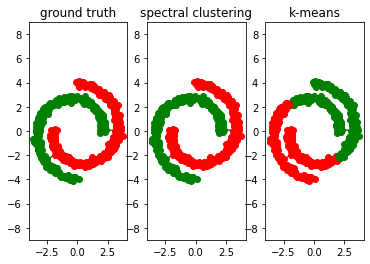

In [80]:
# Example

num_classes = 2
L = build_laplacian(W)
Y_rec = spectral_clustering(L, chosen_eig_indices=[1], num_classes=num_classes)

# Plot results, comparing to KMeans
plot_clustering_result(X, Y, L, Y_rec, KMeans(num_classes).fit_predict(X))

## Parameter sensitivity 

In [166]:
def parameter_sensitivity():
    """
    TO BE COMPLETED.

    A function to test spectral clustering sensitivity to parameter choice.
    """
    # the number of samples to generate
    num_samples = 500

    """
    Choose parameters
    """
    var = 1.0  # exponential_euclidean's sigma^2
    laplacian_normalization = 'unn'
    chosen_eig_indices = [1]

    """
    Choose candidate parameters
    """
    parameter_candidate = np.arange(0, 70, 5) # the number of neighbours for the graph or the epsilon threshold
    parameter_candidate_eps = np.linspace(0, 1, 20)
    parameter_performance = []
    parameter_performance_eps = []

            # Generate data
    X, Y = two_moons(num_samples, 1, 0.02)
    num_classes = len(np.unique(Y))
    
    for k in parameter_candidate:

        W = build_similarity_graph(X, k=k)
        L = build_laplacian(W, laplacian_normalization)
        Y_rec = spectral_clustering(L, chosen_eig_indices, num_classes)
        parameter_performance += [skm.adjusted_rand_score(Y, Y_rec)]
        
    for epsilon in parameter_candidate_eps:
        
        W = build_similarity_graph(X, eps=epsilon)
        L = build_laplacian(W, laplacian_normalization)
        Y_rec = spectral_clustering(L, chosen_eig_indices, num_classes)
        parameter_performance_eps += [skm.adjusted_rand_score(Y, Y_rec)]
        
    epsilon_MST = epsilon_mst(X) 
    plt.figure()
    plt.plot(parameter_candidate, parameter_performance)
    plt.title('parameter sensitivity - K-NN Graph')
    plt.xlabel('$k$')
    plt.show()
    
    plt.figure()
    plt.plot(parameter_candidate_eps, parameter_performance_eps)
    plt.plot([epsilon_MST]*20, np.linspace(0, 1, 20), label = 'Epsilon found with MST')
    plt.title('parameter sensitivity - $\epsilon$-Graph')
    plt.xlabel('$\epsilon$')
    plt.legend()
    plt.show()

## Image segmentation

In [213]:
def image_segmentation(input_img='four_elements.bmp'):
    """
    TO BE COMPLETED

    Function to perform image segmentation.

    :param input_img: name of the image file in /data (e.g. 'four_elements.bmp' or 'fruit_salad.bmp')
    """
    filename = os.path.join('data', input_img)

    X = io.imread(filename)
    X = (X - np.min(X)) / (np.max(X) - np.min(X))

    im_side = np.size(X, 1)
    Xr = X.reshape(im_side ** 2, 3)
    """
    Y_rec should contain an index from 0 to c-1 where c is the     
     number of segments you want to split the image into          
    """

    """
    Choose parameters
    """
    var = 1.0
    k = 2
    laplacian_normalization = 'unn'
    chosen_eig_indices = None
    num_classes = 5

    epsilon = epsilon_mst(Xr)
    W = build_similarity_graph(Xr, var=var, eps = epsilon)
    L = build_laplacian(W, laplacian_normalization)
    Y_rec = spectral_clustering(L, chosen_eig_indices, num_classes=num_classes)

    plt.figure()

    plt.subplot(1, 2, 1)
    plt.imshow(X)

    plt.subplot(1, 2, 2)
    Y_rec = Y_rec.reshape(im_side, im_side)
    plt.imshow(Y_rec)

    plt.show()

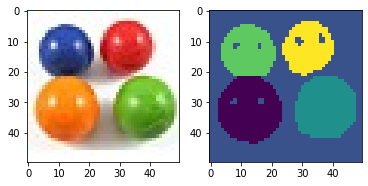

In [214]:
image_segmentation()

# Questions

## Q1: Is it important to build a connected graph? Compare k-NN to $\epsilon$-graphs with respect to the difficulty of building a connected graph. 

Having a connected graph is important for the algorithm. If there exists two distincts components in the graph, then these two components will immediatly define two clusters. So if we want to find 2 clusters, we will immediately have the output. This is not a big issue but this means the user enforces the results. Whereas in a clustering algorithm, we want the algorithm to automatically create the clusters. If, for instance, there are more disconnected components than the true number of clusters, the algorithm will not be able to produce a good result.

Let's investigate the difference between k-NN to $\epsilon$ graphs with respect to the difficulty of building a connected graph.
I chose to plot blops with a high variance so that some points are close to an other cluster.


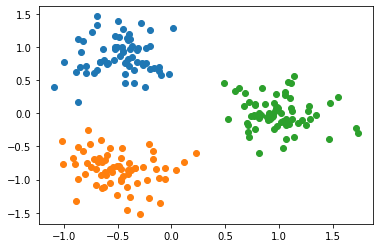

In [19]:
X, Y = blobs(n_blobs=3, num_samples=200, blob_var=0.25)
plot_clusters(X, Y, fignum=str(fn))

### Epsilon graph

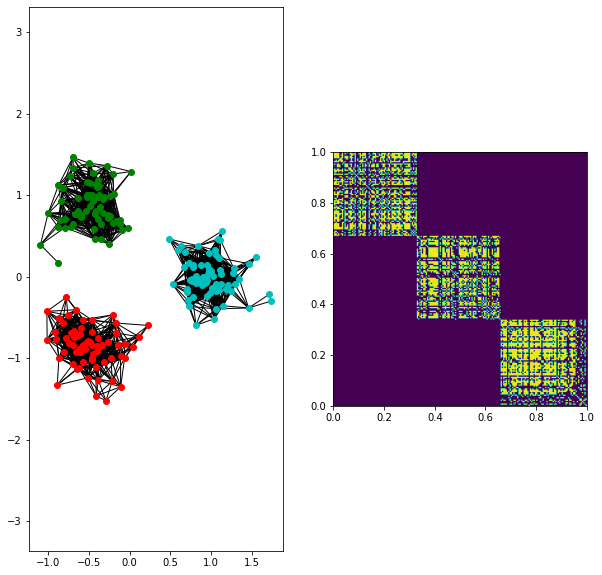

In [23]:
# Example Epsi
W = build_similarity_graph(X, eps=0.92, k=0)
plot_graph_matrix(X, Y, W, figsize=(10, 10))  # shows the graph and the visualization of W

### K-NN Graph

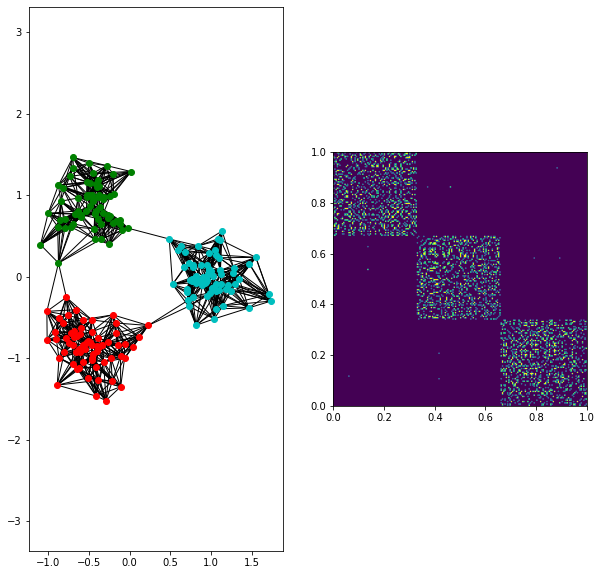

In [27]:
# Example
W = build_similarity_graph(X, k=12)
plot_graph_matrix(X, Y, W, figsize=(10, 10))  # shows the graph and the visualization of W

As we can see on the plots, there is a green point very close to the red cluster. The advantage with k-NN is that if a point is on the edge of a cluster and if the variable $k$ is high compared to the number of element in the cluster, the method will enforce some points of the neighbour cluster (here the red one) to be connected with. This is due to its definition where it enforces each node to have $k$ neighbours. Thus it is easier to construct connected graphs.


On the other hand with epsilon graphs, there is no quota (ie $k$ elements to be linked with) so that if epsilon is too high  ($\epsilon \geq \min_{c_1 \in C_1, c_2 \in C_2} s(c_1, c_2)$) it can be difficult to link together nodes from different clusters. Epsilon graphs link spatially closed points whereas k-NN graph links together a minimum number of points and thus facilitates the connectivity between clusters.

We can also notice on the weight matrices that for the K-NN exemple, the matrix is much more sparse and the associated graph is still connected. However, for the $\epsilon$-Graph, the matrix is much less Sparse within each cluster and the associated graph is not connected. K-NN thus seems to be a better choice.

### Q2: The function `min_span_tree` can be used to choose the value of $\epsilon$ that keeps the graph connected. Using the `worst_case_blob`, can you tell when it is a bad idea to use this approach?

As we have seen in class, it might be interesting to create a minimum spanning tree that connects all the vertices together, without any cycles and with the minimum possible total edge weight. Then we can take the highest distance (or inversely the smaller similarity) to be a good estimate of $\epsilon$. 

Indeed, defining $\epsilon$ in a such way, ensure that the graph is connected (since all the similarities are smaller than $\epsilon$) but this method is not robust to outliers : 

As we can see, using the function worst_case_blob that defines an outlier, the minimum spanning tree will automatically link the outlier to one of the points within the cluster (Otherwise it is not a MST). Thus, the taking the maximum distance (smallest similarity) will enforce $\epsilon$ to be very small, and almost all the points within the cluster will be connected together. The final graph will be fully (or almost) fully connected.

Then, we can observe that the similarity matrix is not sparse at all and thus the graph is almost fully connected.

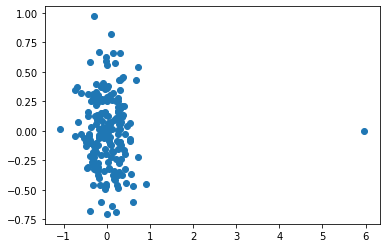

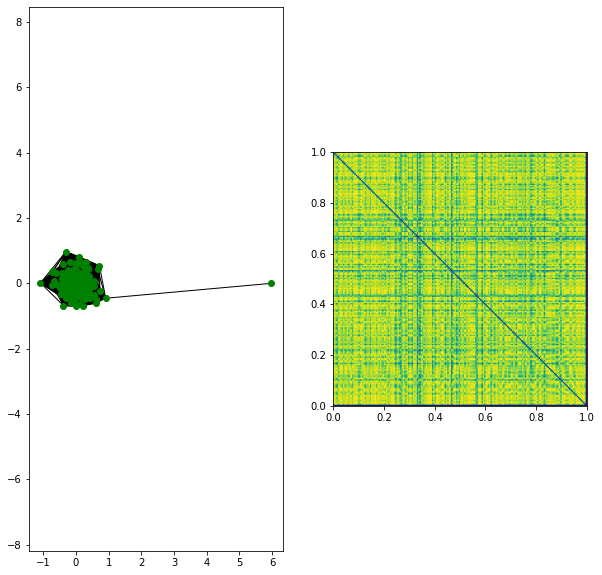

In [88]:
def epsilon_mst(X):
    ## Initialise a graph fully connected
    W = build_similarity_graph(X, var=1.0, eps=0, k=0)
    ## Compute MST and take the smallest similarity
    mst = min_span_tree(-W)
    epsilon = np.min(W[mst])
    return epsilon

X, Y = worst_case_blob(num_samples=200)
plot_clusters(X, Y, fignum='Blobs')

epsilon = epsilon_mst(X)
##Reconstruct a graph with the given epsilon
W = build_similarity_graph(X, var=1.0, eps=epsilon, k=0)
## Plot
plot_graph_matrix(X, Y, W, figsize=(10, 10)) 

However, if we don't introduce an outlier, (we use blobs with n_blops = 1) we can see that we get a fully connected graph with a sparse similarity matrix. Hence the result is quite satisfying.

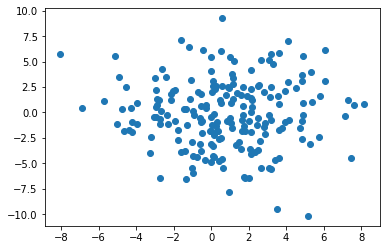

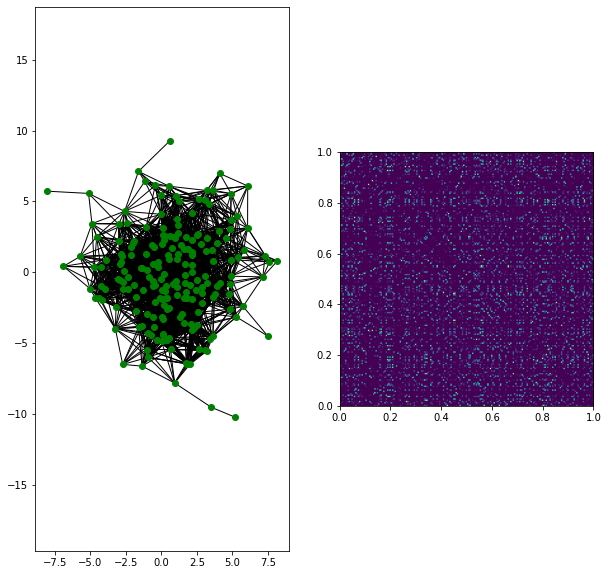

In [89]:
X, Y = blobs(num_samples=200, n_blobs=1, blob_var=3)
plot_clusters(X, Y, fignum=str(fn))


epsilon = epsilon_mst(X)
##Reconstruct a graph with the given epsilon
W = build_similarity_graph(X, var=1.0, eps=epsilon, k=0)
## Plot
plot_graph_matrix(X, Y, W, figsize=(10, 10)) 

### Q3: Build a graph starting from the data generated in `blobs`, and keep the graph connected. Motivate your choice on which eigenvectors to use and how you computed the clustering assignments from the eigenvectors. Now compute a similar clustering using the built-in k-means and compare the results.

We have seen in class that the eigenvector associated with the smallest eigenvalue is constant and the multiplicity of the eigenvector is 1 since the Graph is connected. (The multiplicity equals the number of connected components and the smallest eigenvalue is zero to be precise). Thus using this eigen pair is not useful for clustering.

However, the other eigen pairs are meaningful for the clustering. As we have seen in class, in order to cluster points in 2 groups, the Rayleigh-Ritz theorem ensures that the eigen vector associated with the second smallest (non zero) eigen value of the Laplacian matrix is a minimizer of the relaxed version of the MinCut.
Thus we have a vector, with continuous values in $\mathbb{R}$, solution to the relaxed version of the MinCut. However, we are still looking for a discrete partition (values in $\{-1, 1\}$).

A common heuristic is to take the sign for each component of the second eigen vector as the discrete partition. Or one should apply the k_means $(k = 2)$ algorithm to the rows (components) of this vector.

If we are looking for more than 2 clusters, Ulrike von Luxburg proved in the paper "A tutorial on Spectral Clustering" https://arxiv.org/abs/0711.0189, that for the MinCut problem with $k \geq 3$ clusters : 

$$ min_{A_1, A_2, ..., A_k} cut(A_1, A_2, ..., A_k) = min_{A_1, A_2, ..., A_k} \sum_{k = 1}^kW(A_i, \bar A_i)$$

Where : 
$$W(A, B) := \sum_{i \in A, j \in B} w_{ij}, \text{ and } \bar A \text{ is the complement of } A $$

Rewrites :

$$
\begin{alignat}{2}
&\!\min_{A_1, A_2, ..., A_k}       &\qquad&\text{Tr}(H^TLH)\\
&\text{subject to} &      & H^TH = I\\
&                  &      & H_{ik} = \begin{cases}
                                                1 &  \text{if }V_i \in A_k \\
                                               -1 &  \text{if }V_i \in \bar A_k
                                     \end{cases}
\end{alignat}
$$

The relaxed version of this problem is :

$$
\begin{alignat}{2}
&\!\min_{A_1, A_2, ..., A_k}       &\qquad&\text{Tr}(H^TLH)\\
&\text{subject to} &      & H^TH = I\\
&                  &      & H \text{is a matrix} \in \mathbb{R}^{n, k}\\
\end{alignat}
$$

And the solution of the relaxed version can still be found using the Rayleigh-Ritz theorem, with H being the matrix containing the first k eigenvectors of L as columns.
To get an approximate solution for the non relaxed version of the MinCut we then apply the k-means algorithm on the rows of U.

Let's make a test with the moon dataset (with $k = 2$)

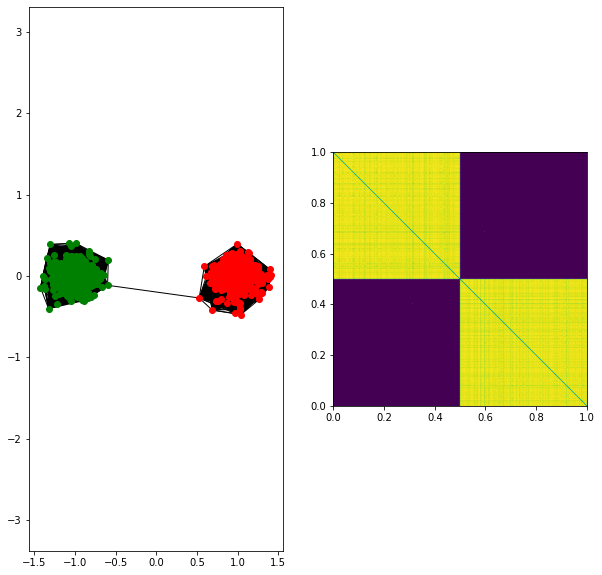

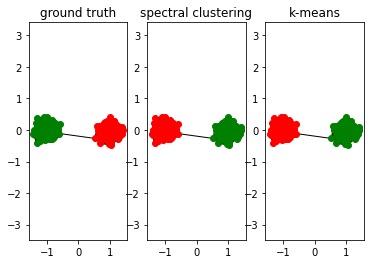

In [40]:
for fn in [blobs]:  #  try also [worst_case_blob, point_and_circle, blobs]
    X, Y = fn(num_samples=600)
    
W = build_similarity_graph(X, eps=0.52, k=0)
plot_graph_matrix(X, Y, W, figsize=(10, 10))  # shows the graph and the visualization of W

# Example

num_classes = 2
L = build_laplacian(W)
Y_rec = spectral_clustering(L, chosen_eig_indices=[1], num_classes=num_classes)

# Plot results, comparing to KMeans
plot_clustering_result(X, Y, L, Y_rec, KMeans(num_classes).fit_predict(X))

We get similar results with the Spectral clustering and the kmeans algorithm. This comes the dataset which is easily linearly separable.

### Q4: In the function spectral_clustering, implement an automatic strategy to choose the eigenvectors to use for clustering, when chosen_eig_indices=None. Explain your strategy. Generate a dataset with 4 blobs and test your function. What happens when the variance of the blobs increase?

I implemented the code in the function defined at the begining of the notebook.
As we have discussed before, the solution of the relaxed problem (continuous variables) with $k \geq 3$ consists in finding the k-first of the matrix $H$ created with the first k eigenvectors of L as columns. In practice, if the graph is connected, we can remove the eigen vector associated with the smallest eigen value. Thus we can only take the $k-1$ non zero eigenvalues and the eigenvectors associated.
In the following experiment, I chose 3 different initializations of the datapoints using the blobs method and I increased the $\sigma$ variance of the blobs.

As expected, by increasing the variance, the datapoints tend to be more and more spread across their mean. And for a high variance some points start to merge with other clusters. We expect that the clustering will be more and more difficult.

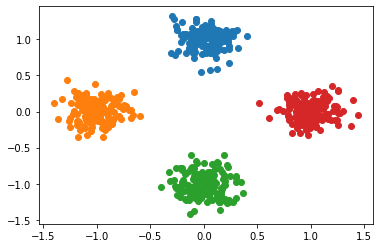

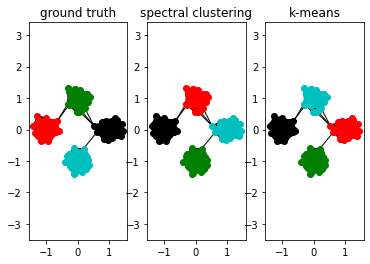

In [126]:
X, Y = blobs(num_samples=600, n_blobs=4, blob_var=0.15)
plot_clusters(X, Y)

epsilon = epsilon_mst(X)
##Reconstruct a graph with the given epsilon
W = build_similarity_graph(X, var=1.0, eps=epsilon, k=0)
# Example
num_classes = 4
L = build_laplacian(W, laplacian_normalization='unn')
Y_rec = spectral_clustering(L, chosen_eig_indices=None, num_classes=num_classes)
plot_clustering_result(X, Y, L, Y_rec, KMeans(num_classes).fit_predict(X))

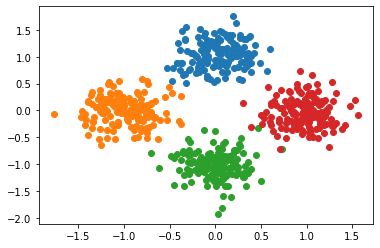

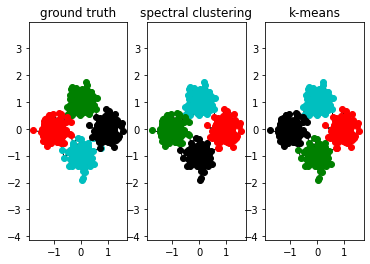

In [130]:
X, Y = blobs(num_samples=600, n_blobs=4, blob_var=0.25)
plot_clusters(X, Y)

epsilon = epsilon_mst(X)
##Reconstruct a graph with the given epsilon
W = build_similarity_graph(X, var=1.0, eps=epsilon, k=0)
# Example
num_classes = 4
L = build_laplacian(W)
Y_rec = spectral_clustering(L, chosen_eig_indices=None, num_classes=num_classes)
plot_clustering_result(X, Y, L, Y_rec, KMeans(num_classes).fit_predict(X))

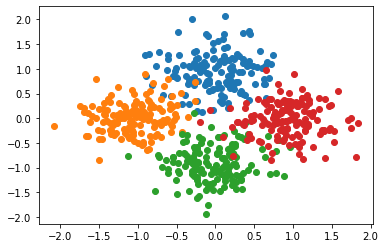

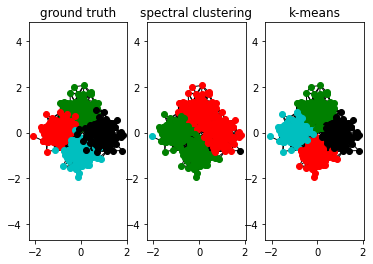

In [131]:
X, Y = blobs(num_samples=600, n_blobs=4, blob_var=0.35)
plot_clusters(X, Y)

epsilon = epsilon_mst(X)
##Reconstruct a graph with the given epsilon
W = build_similarity_graph(X, var=1.0, eps=epsilon, k=0)
# Example
num_classes = 4
L = build_laplacian(W)
Y_rec = spectral_clustering(L, chosen_eig_indices=None, num_classes=num_classes)
plot_clustering_result(X, Y, L, Y_rec, KMeans(num_classes).fit_predict(X))

As we can see, increasing too high the variance leads to a bad clustering. This is because the datapoints are not easily separable and they become closer to other clusters. And thus the algorithm find relevant only some bigger clusters. We can see that it detects 2 clusters (red and green) but also keep single points (blue and black) as the last two clusters. The result is quite bad but the task itself is much more difficult.

### Q5: When you built the cluster assignment, did you use thresholding, k-means or both? Do you have any opinion on when to use each?

I tried both methods (and implemented both in the parameter_sensitivity function). The thresholding consists in assigning the label $+1$ if the component of the eigen-vector is positive, $-1$ otherwise. This method only works with two clusters. If we have more than 2 clusters, we need to convert the continuous values $H_{ik}$ (with $H$ defined before) into discrete values, and we cannot have a single point in two different clusters (that is $H_{ik} = 1$ and $H_{jk} = 1$), thus we need to modify our strategy.

A simple way to do that may be, for a point $i$, to assign 1 to the component $k = \text{argmax}_k(H_{ik})$, and $-1$ for the other components. 

The advantage of this methods (thresholding for $k=2$ or taking the argmax for $k > 2$) is that they are extremely easy and fast to compute but they may lack some flexibility. 
On the other hand, using the kmeans is a little bit slower (but still very fast) but it is much more flexible and general. And it can recover the policy (thresholding for $k=2$ or taking the argmax for $k > 2$).

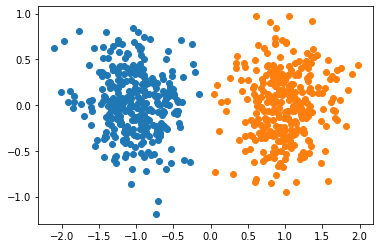

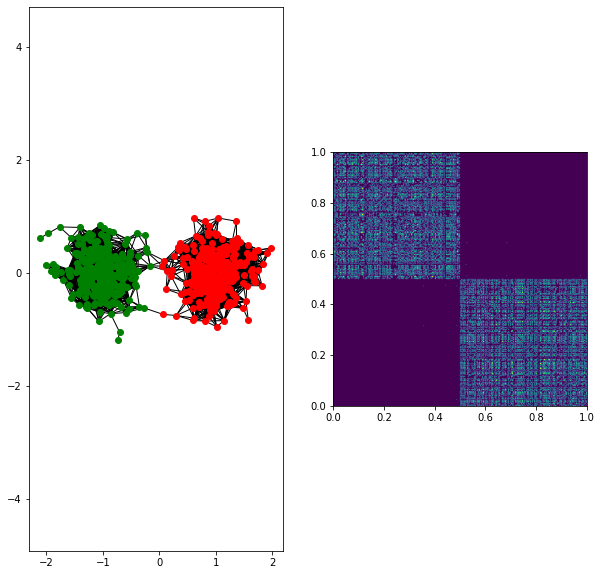

Kmeans


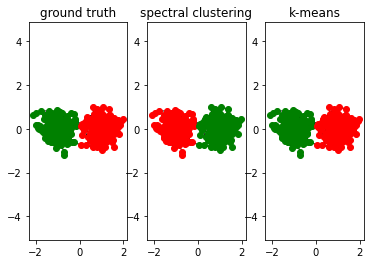

Sign Function


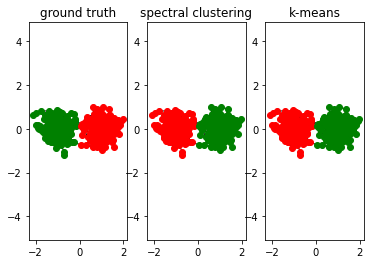

In [172]:
X, Y = blobs(num_samples=600, n_blobs=2, blob_var=0.35)
num_classes=2
plot_clusters(X, Y)
epsilon = epsilon_mst(X)
W = build_similarity_graph(X, eps=epsilon, k=0)
L = build_laplacian(W)
plot_graph_matrix(X, Y, W, figsize=(10, 10))  # shows the graph and the visualization of W
print("Kmeans")
Y_rec = spectral_clustering(L, chosen_eig_indices=None, num_classes=num_classes)
plot_clustering_result(X, Y, L, Y_rec, KMeans(num_classes).fit_predict(X))
print("Sign Function")
Y_rec = spectral_clustering(L, chosen_eig_indices=None, num_classes=num_classes, kmeans=False)
plot_clustering_result(X, Y, L, Y_rec, KMeans(num_classes).fit_predict(X))

As expected we recover the same results (with kmeans and with thresholding) since the problem is linearly separable.

### Q6: Generate `two_moons` data and compare spectral clustering to k-means. Do you notice any difference? Taking into consideration the graph structure, can you explain them?

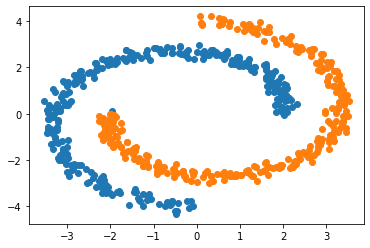

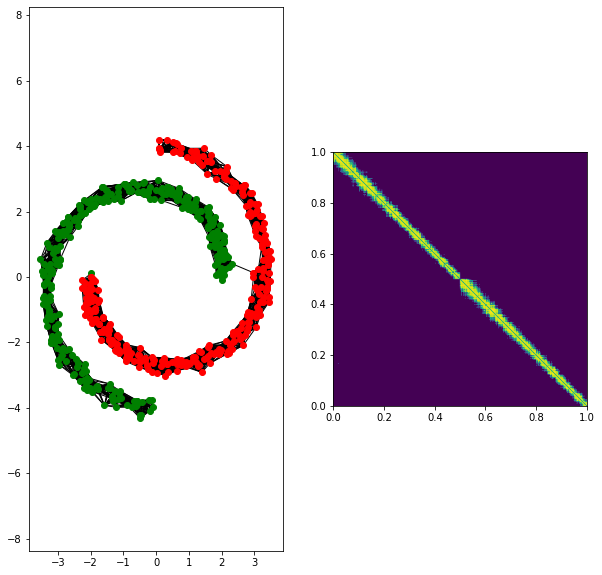

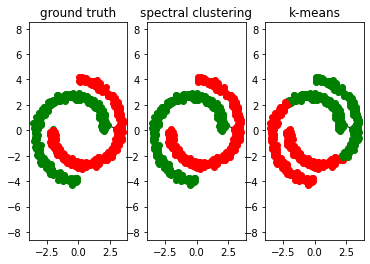

In [147]:
X, Y = two_moons(num_samples=600)
plot_clusters(X, Y)
epsilon = epsilon_mst(X)
W = build_similarity_graph(X, eps=epsilon, k=0)
plot_graph_matrix(X, Y, W, figsize=(10, 10))  # shows the graph and the visualization of W

# Example
num_classes = 2
L = build_laplacian(W)
Y_rec = spectral_clustering(L, chosen_eig_indices=None, num_classes=num_classes)
plot_clustering_result(X, Y, L, Y_rec, KMeans(num_classes).fit_predict(X))

As we can see in the results, the results for the spectral clustering are excellent. The algorithm manages to find the clusters even if the structure of the clusters is not convex at all.
However, the kmeans fails to find the two clusters. This came from the fact that kmeans usually works for convex clusters (or linearly separable ones). Using the graph strucutre of the points is very beneficial since it allows the algorithm to find complex structures (non linear).

### Q7: Generate `point_and_circle` data and compare spectral clustering using the normal Laplacian and the random-walk regularized Laplacian. Do you notice any difference? Taking into consideration the graph structure, can you explain them?

We consider the dataset 'point_and_circle' and compare the clusterings using the unnormalized Laplacian and the Random-Walk Laplacian. For both Laplacians, we use the same X, Y (with $\epsilon = 0.26$), and the same associated graph.

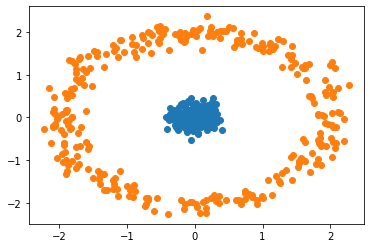

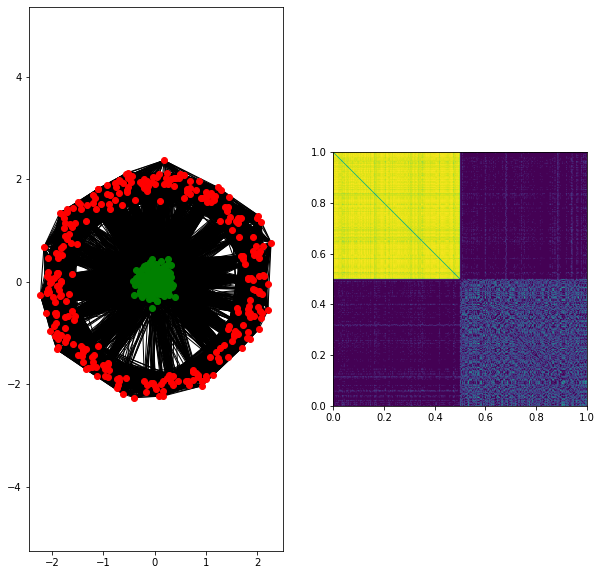

In [196]:
X, Y = point_and_circle(num_samples=600)
plot_clusters(X, Y)
W = build_similarity_graph(X, eps=0.26, k=0)
plot_graph_matrix(X, Y, W, figsize=(10, 10))  # shows the graph and the visualization of W

Unnormalized Laplacian


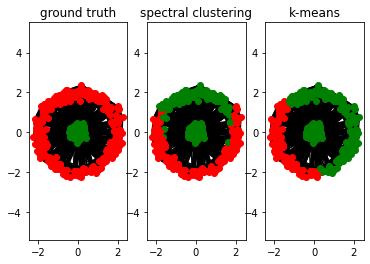

In [202]:
# Example
print('Unnormalized Laplacian')
num_classes = 2
L = build_laplacian(W, )
Y_rec = spectral_clustering(L, chosen_eig_indices=[1], num_classes=num_classes)
plot_clustering_result(X, Y, L, Y_rec, KMeans(num_classes).fit_predict(X))

Random Walk Laplacian


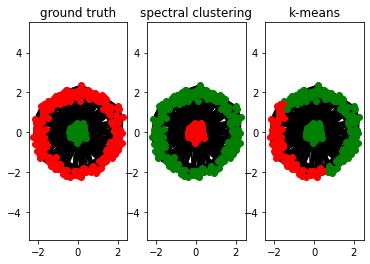

In [204]:
# Example
print('Random Walk Laplacian')
num_classes = 2
L = build_laplacian(W, laplacian_normalization = 'rw')
Y_rec = spectral_clustering(L, chosen_eig_indices=[1], num_classes=num_classes)
plot_clustering_result(X, Y, L, Y_rec, KMeans(num_classes).fit_predict(X))

As we can see the Random Walk Laplacian performs better than the Unnormalized Laplacian for the same example. We know that the random-walk laplacian is used to minimize the NCut problem whereas the unnormalized Laplacian is used to minimize the RatioCut problem. The difference we get comes from the difference between the two problems.

In the NCut (random-walk laplacian) we try to separate the clusters but we weight the cuts with the volume (and thus the sum of weights ) of each cluster. On the other hand , in the RatioCut (Unnormalized Laplacian) we try to separate the clusters but we weight the cuts with the cardinal of each cluster.

This implies that with the NCut (random-walk laplacian), the algorithm will try to have high volumes for each cluster and we can see on the first plot that the volumes of the green circle and the red one are high (because the points are closed to each other).
On the other hand, with the RatioCut (random-walk laplacian), the algorithm will try to have high cardinal for each cluster and we can see on the second plot that the number of samples in each clusters are almost equivalent (proportion of 1/2 : 1/2), but the volume of each cluster are lower (some points are far from each other).

### Q8: Using the function parameter_sensitivity, comment on the stability of spectral clustering when varying $\epsilon$ or k. 

In this question, we compute the adjusted Rand index (supervised metric) between the true labels and the labels from our clustering for a various number of hyperparameters ($\epsilon$ and $k$).
This metric measures the agreement ratio of a clustering compared to the true one. It is between 0 and 1 and the higher, the better.

For each case, we can see that there is a range (10-30 for k-NN and 0.62-0.95 for $\epsilon$) where the clustering are very good.
For both methods, if the parameter is too high, we will have an almost fully connected graph making the clustering difficult. And if the parameter is too low, we will have a Graph with disconnected components, or even worse we will have isolated points. The latter will result in a bad clustering since the graph doesn't capture the true links between the points.

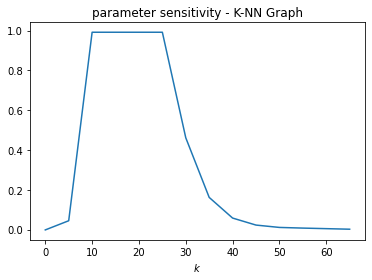

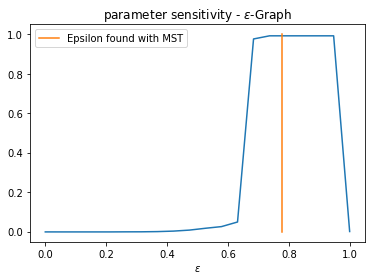

In [168]:
parameter_sensitivity()

### Q9: If we did not have access to "true" labels, how could we evaluate the clustering result (or what should we not use as evaluation)?

As we don't have the true labels anymore, it is impossible to compare the labels with the result of our clustering. (For instance we cannot use adjusted rand index as we did above since we don't have the labels anymore).
We need to use unsupervised metrics.

A bad idea would be to use only within-cluster criteria, for instance intra-cluster inertia (with $n_i$ the size of cluster $i$, $\mu_i$ the barycenter of cluster $i$ and $G_i$ the set of elements in cluster $i$): 
$$\sum_{i = 1}^k \sum_{e \in G_i}^n n_i \Vert e - \mu_i \Vert^2$$
This type of metric only consider that the points of a cluster are closed to their centroid. For instance, with the point and circle exemple below, the centroid of the orange cluster (barycenter) is (0, 0) and thus we would have an important inertia since the orange points are far from the center.

Or similarly a bad idea would be to use only an extra-cluster criteria, for instance extra-cluster inertia (with $\mu$ the global barycenter of the datapoints and $G_i$ the set of elements in cluster $i$):
$$\sum_{i = 1}^k \Vert x_i - \mu \Vert^2$$

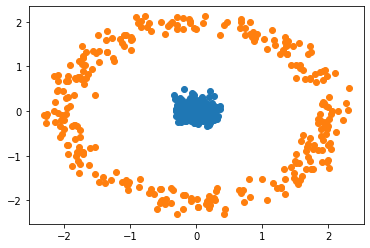

In [206]:
X, Y = point_and_circle(num_samples=600)
plot_clusters(X, Y)

A better idea would be to combine within-cluster critera and extra-cluster criteria. For instance we could use the silhouette Index which combines the two : 

For a point $i$ in cluster $k=C(i)$. 
It computes $a(i)=\frac{1}{\left|I_{k}\right|-1} \sum_{j \in I_{k}, j \neq i} d\left(x^{i}, x^{j}\right)$ 
and  $b(i)=\min _{k^{\prime} \neq k} \frac{1}{\left|I_{k^{\prime}}\right|} \sum_{i^{\prime} \in I_{k^{\prime}}} d\left(x^{i}, x^{i^{\prime}}\right)$. 

The final coefficient of the point $i$ is:
$$
s_{s i l}(i)=\frac{b(i)-a(i)}{\max (a(i), b(i))}
$$
Overall, the global coefficient is 
$$
S_{s i l}=\frac{1}{K} \sum_{k=1}^{K} \frac{1}{\left|I_{k}\right|} \sum_{i \in I_{k}} s_{s i l}(i)
$$

This metric takes into consideration both criteria (with $a$ and $b$).
However, there is a lot of others metrics (Modularity, Conductance, Coverage etc...) and there is no absolute truth since we don't have the true labels. Then, using one of these metrics might result in very different scores.

### Q10: A full graph built between the pixels of a 50 × 50 image corresponds to $50^2$ nodes. Solving the full eigenvalue problem in this case would scale in the order of $2^{34}$ . Even on weak hardware this takes only seconds to minutes. Segmenting a Full HD picture of 1920 × 1080 would scale in the order of $2^{64}$ (about a month on a decent machine). Beyond that, the large picture would require to store in memory a graph over millions of nodes. A full graph on that scale requires about 1TB of memory. Can you think two simple techniques to reduce the computational and occupational cost of Spectral Clustering?

Computing the spectral clustering on a real image ($\approx$ 1920 × 1080 pixel) can indeed be challenging.
The main issue comes from two factors :
* The complete graph can have a huge number of nodes as the computations scale up with the number of nodes. This directly impacts  the final complexity.
* The main computation within the spectral clustering is the computation of the eigenvalues and the eigenvectors. And the trivial algorithm usually need $\mathcal{O}(n^3)$ (with $n$ the number of nodes) operations.

So two ways of simplifying the problem might be tackling each one of this issues.

Firstly, we may consider effective ways of computing the eigen vectors. Many options exist in this case : 
* As the laplacian matrix is usually quite sparse, using COO or CSR sparse matrix and dedicated matrix operations can considerably lower the computational cost and the occupational cost (cf LAPACK functions).
* We can also use eigenvalues algorithm to compute only the eigenvectors associated with the $m$ lowest (or highest) eigenvalues. This allows us to reduce considerably the computational cost since we don't have to do the computation for every eigenvectors. (See for exemple Langzos, Power Iteration, Arnoldi algorithms).

Another idea is to reduce the complexity of the Laplacian graph.
* We can downsample the image before feeding it to the spectral clustering algorithm.
* We can use quantization methods to reduce the number of nodes. For example we can replace a group of $M$ points with their barycenter. This would approximately divide the number of points by $M$ and thus be way more effective. 
* We could also use k-means beforehand to identify obvious clusters. Then we can replace the clusters with their centroids and run the spectral clustering algorithm.